In [1]:
# 1. Import required modules
from anomalib.data import MVTecAD
from anomalib.engine import Engine
from anomalib.models import EfficientAd

/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/vantuan_ngo/.local/lib/python3.10/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


In [2]:
# 2. Create a dataset
# MVTecAD is a popular dataset for anomaly detection
datamodule = MVTecAD(
    root="./datasets/MVTecAD",  # Path to download/store the dataset
    category="bottle",  # MVTec category to use
    train_batch_size=1,  # Number of images per training batch
    eval_batch_size=32,  # Number of images per validation/test batch
    num_workers=8,  # Number of parallel processes for data loading
)

In [3]:
# 3. Initialize the model
# EfficientAd is a good default choice for beginners
model = EfficientAd()

In [4]:
# 4. Create the training engine
engine = Engine(max_epochs=10)  # Train for 10 epochs

In [30]:
# 5. Train the model
engine.fit(datamodule=datamodule, model=model)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                     | Type             | Params | Mode
---------------------------------------------------------------------
0 | pre_processor            | PreProcessor     | 0      | eval
1 | post_processor           | PostProcessor    | 0      | eval
2 | evaluator                | Evaluator        | 0      | eval
3 | model                    | EfficientAdModel | 8.1 M  | eval
4 | data_transforms_imagenet | Compose          | 0      | eval
---------------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.235    Total estimated model params size (MB)
0         Modules in train mode
56        Modules in eval mode
`Trainer.fit` stopped: `max_epochs=10` reached.


In [7]:
# load best model from checkpoint before evaluating
test_results = engine.test(
    model=model,
    datamodule=datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
Restoring states from the checkpoint path at /home/vantuan_ngo/anomalib-example/results/EfficientAd/MVTecAD/bottle/v0/weights/lightning/model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/vantuan_ngo/anomalib-example/results/EfficientAd/MVTecAD/bottle/v0/weights/lightning/model.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │    0.9919999837875366     │
│        pixel_AUROC        │    0.9692126512527466     │
│       pixel_F1Score       │    0.7451343536376953     │
└───────────────────────────┴───────────────────────────┘

In [8]:
print(test_results)

[{'image_AUROC': 1.0, 'image_F1Score': 0.9919999837875366, 'pixel_AUROC': 0.9692126512527466, 'pixel_F1Score': 0.7451343536376953}]


In [10]:
from anomalib.deploy import ExportType
engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
)

/home/vantuan_ngo/.local/lib/python3.10/site-packages/torch/onnx/utils.py:1963: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(
/home/vantuan_ngo/.local/lib/python3.10/site-packages/anomalib/models/image/efficient_ad/torch_model.py:66: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None].to(x.device)
/home/vantuan_ngo/.local/lib/python3.10/site-packages/anomalib/models/image/efficient_ad/torch_model.py:67: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you ca

PosixPath('/home/vantuan_ngo/anomalib-example/results/EfficientAd/MVTecAD/bottle/latest/weights/openvino/model.xml')

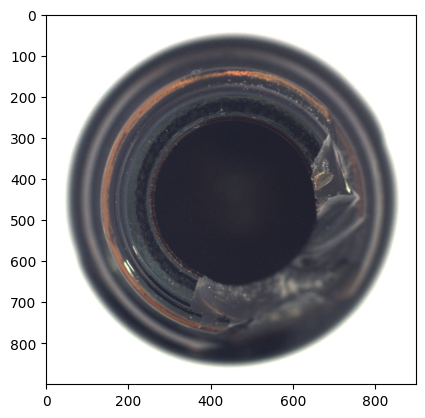

In [14]:
from anomalib.data.utils import read_image
from matplotlib import pyplot as plt
image_path = "./datasets/MVTecAD/bottle/test/broken_large/000.png"
image = read_image(path="./datasets/MVTecAD/bottle/test/broken_large/000.png")
plt.imshow(image)

In [16]:
import os
from pathlib import Path
output_path = Path(engine.trainer.default_root_dir)
print(output_path)

/home/vantuan_ngo/anomalib-example/results/EfficientAd/MVTecAD/bottle/latest


In [17]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
print(openvino_model_path.exists())

True


In [19]:
from anomalib.deploy import OpenVINOInferencer
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    device="CPU",  # We would like to run it on an Intel CPU.
)

In [21]:
from anomalib.utils.visualization import ImageResult
predictions = inferencer.predict(image=image_path)
predictions = ImageResult.from_dataset_item(predictions.items[0])  # convert to imageresult for visualization

In [22]:
print(predictions.pred_score, predictions.pred_label)

0.5092185 True


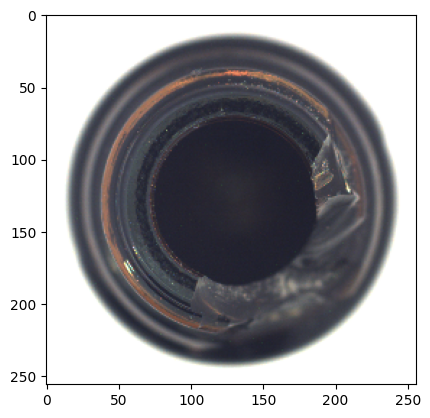

In [23]:
# Visualize the original image
plt.imshow(predictions.image)

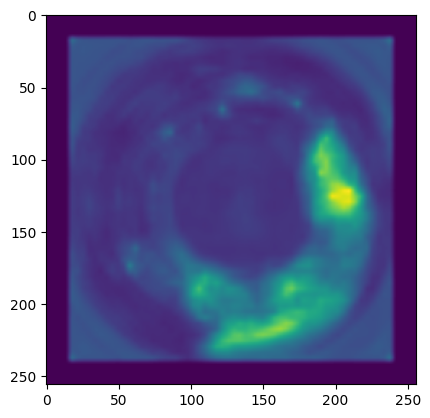

In [24]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

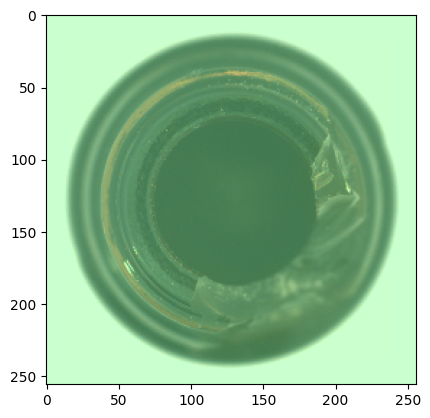

In [25]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

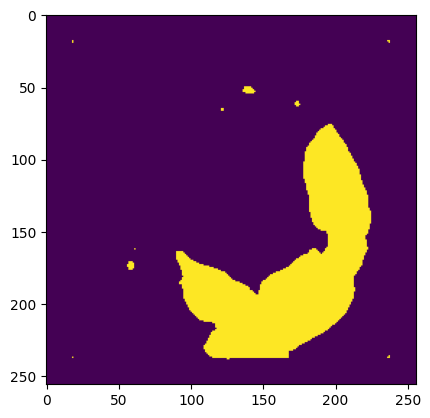

In [26]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

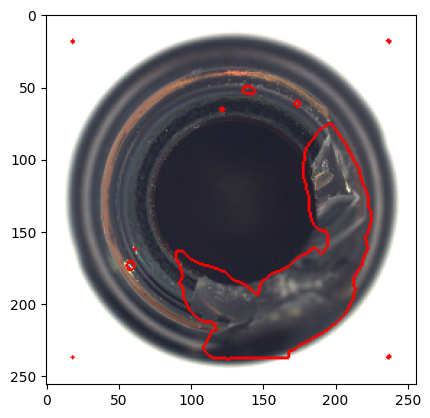

In [27]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)